## CNN Unet Model with Distance as additional Feature 


### w/o MLD


In [81]:
#import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_images,inverse_scale_image, preprocess_image_reduced

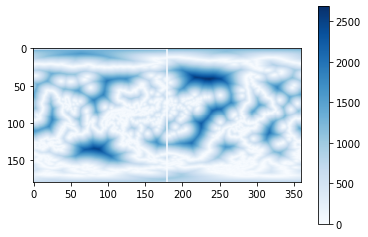

In [82]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)

dir_name = "../../data/data1"
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name)
#dist_map[np.isnan(pco2.pCO2.data[0])]=0.0
# not blocking out the continent makes night and day diff
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)


plt.imshow(dist_map[0],cmap="Blues")
plt.colorbar()

In [83]:

chl_images = preprocess_image_reduced(chl.Chl.data)
#mld_images = preprocess_image_reduced(mld.MLD.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
pco2_images = preprocess_image_reduced(pco2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
    
#X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images,dist_map))
#X = X.reshape((421,180,360,6),order='F')
X = np.dstack((chl_images, sss_images, sst_images, xco2_images,dist_map))
X = X.reshape((421,180,360,5),order='F')

INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

In [84]:
tf.keras.backend.clear_session()

In [85]:
tf.keras.backend.clear_session()

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.Dropout(0.2),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])



base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [86]:
myLearnRate=0.0005
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt)

In [87]:
model_path="../models/base_model/u_net_dist.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=500, 
                         validation_data=(X,pco2_images),
                         workers=-1,batch_size=16,
                         callbacks=callbacks)


Epoch 1/500
27/27 [==============================] - 5s 178ms/step - loss: 104.5669 - val_loss: 21.5074
Epoch 2/500
27/27 [==============================] - 4s 149ms/step - loss: 23.3671 - val_loss: 18.4830
Epoch 3/500
27/27 [==============================] - 4s 149ms/step - loss: 18.6372 - val_loss: 16.6712
Epoch 4/500
27/27 [==============================] - 4s 149ms/step - loss: 16.7255 - val_loss: 16.0036
Epoch 5/500
27/27 [==============================] - 4s 149ms/step - loss: 15.3055 - val_loss: 13.3147
Epoch 6/500
27/27 [==============================] - 4s 149ms/step - loss: 13.5415 - val_loss: 12.0079
Epoch 7/500
27/27 [==============================] - 4s 149ms/step - loss: 12.2283 - val_loss: 13.0029
Epoch 8/500
27/27 [==============================] - 4s 149ms/step - loss: 11.9903 - val_loss: 9.9200
Epoch 9/500
27/27 [==============================] - 4s 149ms/step - loss: 10.1881 - val_loss: 8.9927
Epoch 10/500
27/27 [==============================] - 4s 149ms/step - loss

In [88]:

best_model = tf.keras.models.load_model('../models/base_model/u_net_dist.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 70ms/step


In [89]:
predicted_image[pco2_images==0]=0.0

In [90]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name)

y_true,y_pred = inverse_scale_image(predicted_image,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [91]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())





Full RMSE score:
8.573707746381563
SOCAT RMSE score:
9.069082766557957


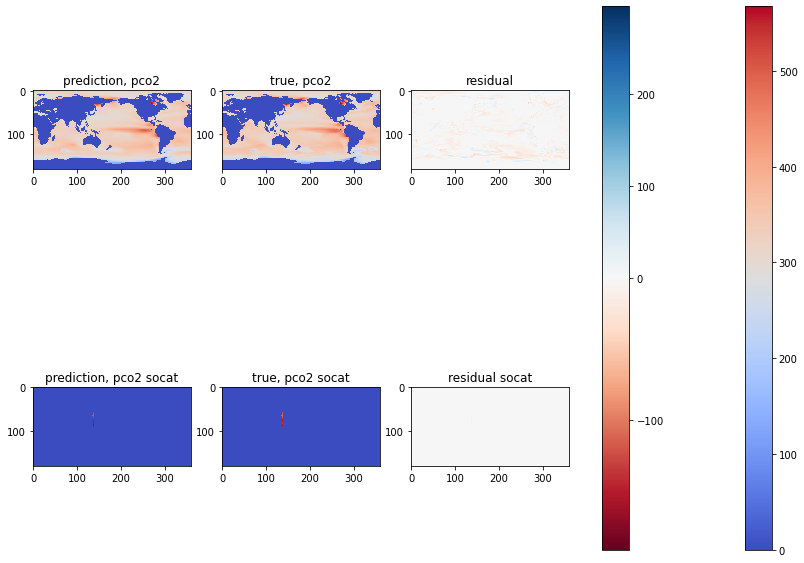

In [92]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

### With MLD

In [93]:

chl_images = preprocess_image_reduced(chl.Chl.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
pco2_images = preprocess_image_reduced(pco2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
    
X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images,dist_map))
X = X.reshape((421,180,360,6),order='F')


INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 6)

In [94]:
tf.keras.backend.clear_session()

In [95]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.Dropout(0.2),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])



base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4832      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [97]:
myLearnRate=0.0005
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt)

In [98]:
model_path="../models/base_model/u_net_dist_withmld.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=500, 
                         validation_data=(X,pco2_images),
                         workers=-1,batch_size=16,
                         callbacks=callbacks)

Epoch 1/500
27/27 [==============================] - 6s 186ms/step - loss: 84.4133 - val_loss: 17.9463
Epoch 2/500
27/27 [==============================] - 4s 152ms/step - loss: 18.0159 - val_loss: 15.1646
Epoch 3/500
27/27 [==============================] - 4s 152ms/step - loss: 15.2475 - val_loss: 13.0858
Epoch 4/500
27/27 [==============================] - 4s 152ms/step - loss: 13.2875 - val_loss: 11.1079
Epoch 5/500
27/27 [==============================] - 4s 152ms/step - loss: 11.8498 - val_loss: 9.5619
Epoch 6/500
27/27 [==============================] - 4s 152ms/step - loss: 10.2399 - val_loss: 10.0232
Epoch 7/500
27/27 [==============================] - 4s 152ms/step - loss: 9.7015 - val_loss: 7.5213
Epoch 8/500
27/27 [==============================] - 4s 151ms/step - loss: 8.2028 - val_loss: 6.5691
Epoch 9/500
27/27 [==============================] - 4s 152ms/step - loss: 7.4709 - val_loss: 6.4474
Epoch 10/500
27/27 [==============================] - 4s 152ms/step - loss: 7.04

In [99]:

best_model = tf.keras.models.load_model('../models/base_model/u_net_dist_withmld.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)
predicted_image[pco2_images==0]=0.0

14/14 [==============================] - 1s 71ms/step


In [100]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name)

y_true,y_pred = inverse_scale_image(predicted_image,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [101]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())

Full RMSE score:
11.525269640176157
SOCAT RMSE score:
12.208557800925368
